# Modèle de Prédiction/Estimation du prix de bien immobilier

In [ ]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Loading real estate dataset from drive

path = "/content/drive/MyDrive/real_estate.csv"
df = pd.read_csv(path)
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


**Objectif: Prédire le prix d'un bien immobilier (le prix d'une maison en fonction d'autres condition stockées comme des données dans les  variables X.)**

Commençons déjà par une analyse exploratoire.

## 📊 EDA

In [ ]:
df.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


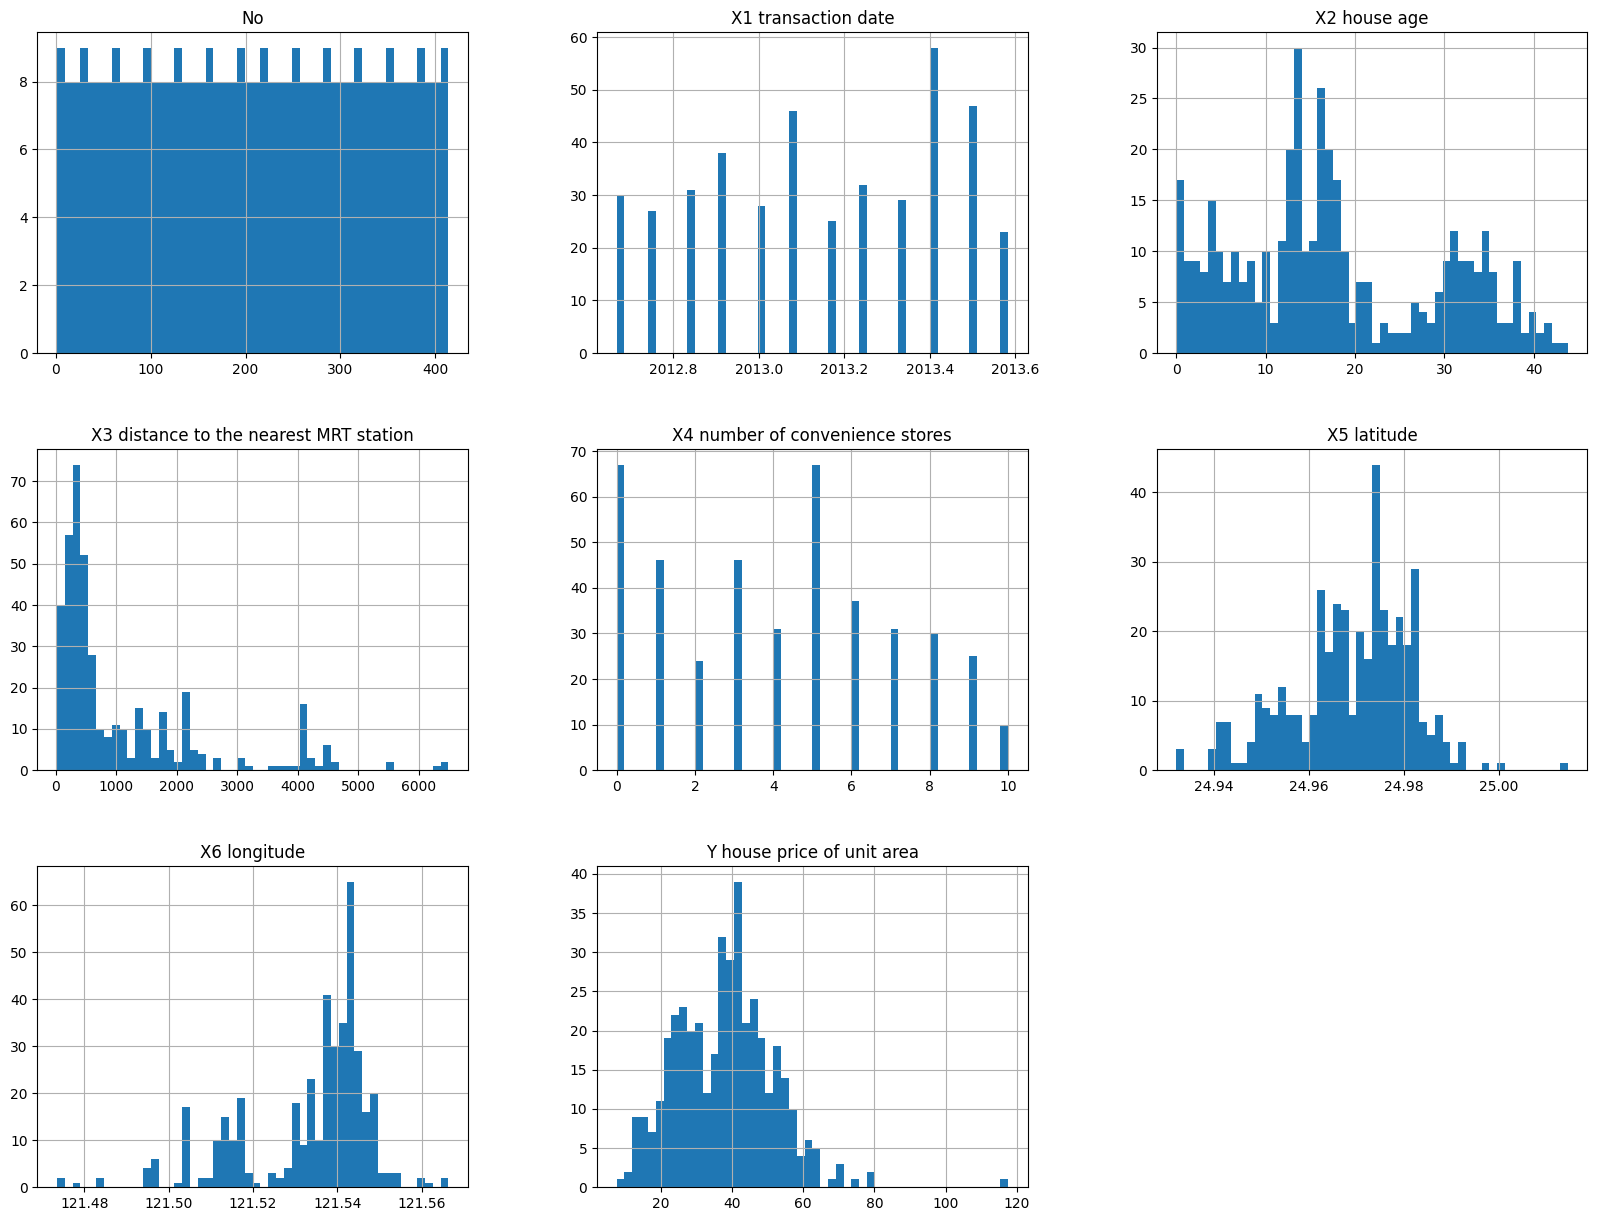

In [ ]:
#Distributions
df.hist(bins = 50, figsize = (20,15))
plt.show()

### Analyse bivariée
Comment les variables interagissent? Des liaisons? des corrélations?

Dans notre cas, nous calculerons les corrélation car nous avons à faire à des variables quantitatives. Pour cela:
* Nous calculons la matrice de corrélations
* Nous affichons les valeurs sous forme de Heatmap


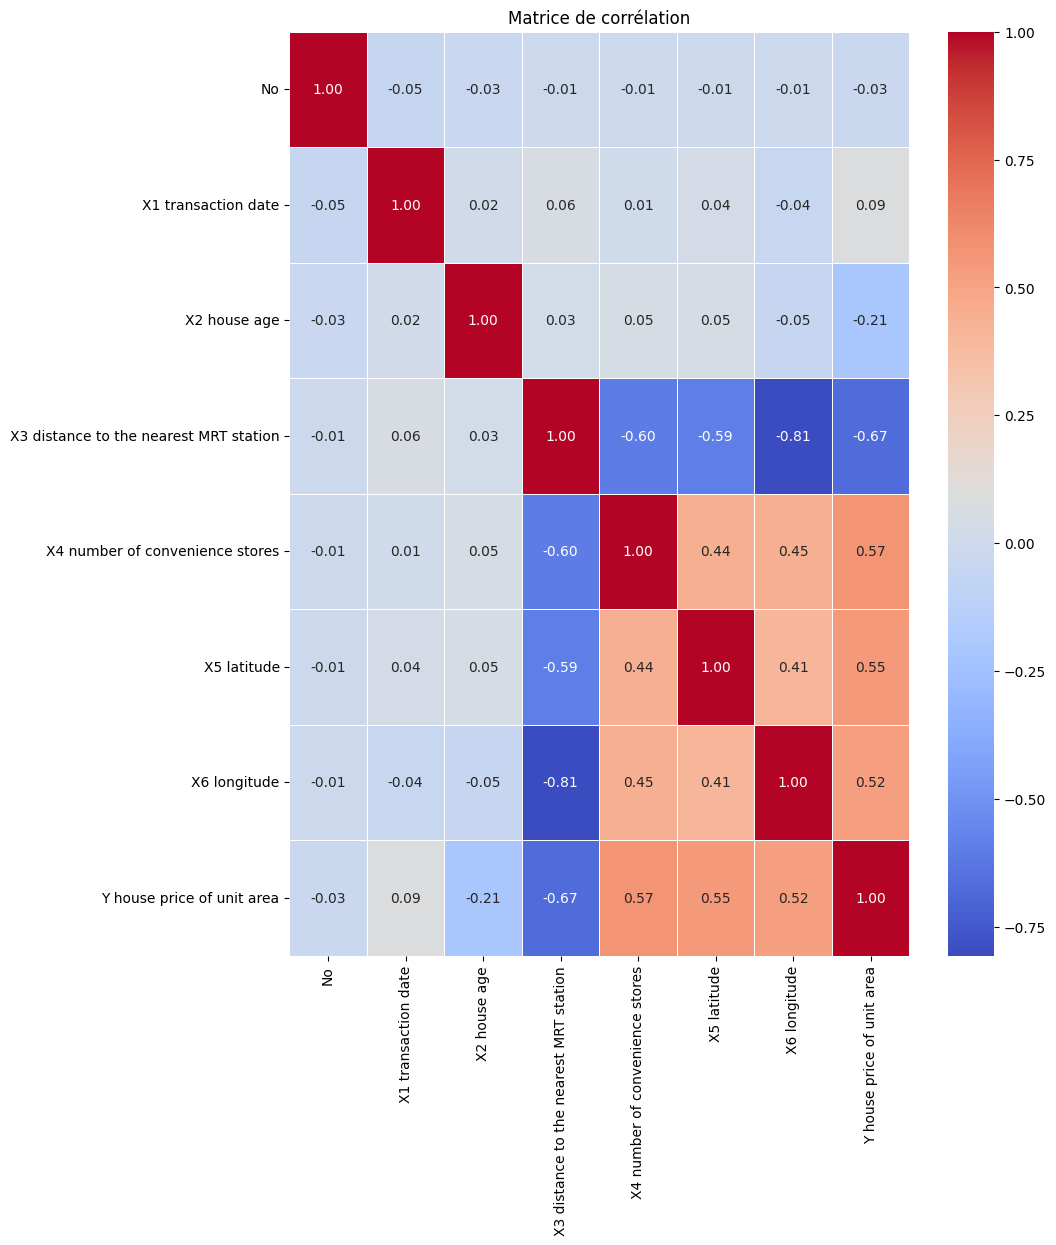

In [ ]:
#Calcul de la matrice de corrélation

matrice_corr = df.corr()

#Afficher les valeur sous forma de Heatmap
plt.figure(figsize = (10,12))
sns.heatmap(matrice_corr, annot=True, cmap ="coolwarm", fmt = ".2f", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

Nous remarquons qu'il existe des corrélation plus ou moins intressantes entre nos variables, qu'elles soient fortes ou faibles. Nous remarquons surtout une corrélation moyenne entre la plupart des variables.

    Interprétation
  * les corrélations négative fortes (proches de -1): Entre deux variables qui s'influence de manière opposée. Quand l'une augmente de valeur, l'autre diminue.
  
    **Ex : "X3 distance to nearest MRT station" avec  "X6 longitude", "X4 number of convenience stores" puis "Y price of unit area"**

 * les corrélations positives fortes (proches de +1): Entre des variables qui s'influencent de manière positive. Quand l'une augmante, l'autre tend à s'augmenter également.

    **Ex: "Y price of unit area" avec "X4 number of convenience store", "X5 latitude" puis "X6 longitude".**

En se reférant au contexte métier, on peut comprendre que ces corrélations sont plosibles:

Plus il y a de d'espace dans une pièce, plus sa valeur sur le marché de l'immobilier est élevée.
Plus il y a d'épiceries près d'un bien immobilier, plus cette zone est urbanisée ou mise en valeur d'où son prix potentiellement élevé.

In [ ]:
#Extraire uniquement les corrélations supérieures à 0,60
threshold = 0.60
strong_corr = matrice_corr[(matrice_corr > threshold) & (matrice_corr != 1.0)]
print("🔍 Corrélations fortes :\n", strong_corr.dropna(how="all").dropna(axis=1, how="all"))

🔍 Corrélations fortes :
 Empty DataFrame
Columns: []
Index: []


Nous remarquons que nous avons peu de corrélations positives fortes, elles sont toutes moyennes. Ce qui signifie que les variables posivement corrélées ne s'influencent que moyennement.

## Preprocessing: Discrétisation de la variable target

Pour l'estimation du prix par unité d'espace, nous avons besoin de  transformer nos données target en des intervalles. Cela permettra d'avoir en lieu ét place des prix exacts à prédire des intervalles de prix précis, ce qui ransforme notre target en une variable discrète.

In [ ]:
#Import de l'algo KBinsDiscretizer pour une dicrétisation automatique:
from sklearn.preprocessing import KBinsDiscretizer

#Initialisation
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy = 'quantile')

#Transformation des prix
df['Ordinal Y'] = discretizer.fit_transform(df[['Y house price of unit area']])

#Récupérer les intervalles
bin_edges = discretizer.bin_edges_[0]

# Affichage des résultats
print("Bornes des intervalles des prix(Y):", bin_edges)
print(df[['Y house price of unit area', 'Ordinal Y']].head())

Bornes des intervalles des prix(Y): [  7.6   25.42  34.62  41.2   48.32 117.5 ]
   Y house price of unit area  Ordinal Y
0                        37.9        2.0
1                        42.2        3.0
2                        47.3        3.0
3                        54.8        4.0
4                        43.1        3.0


In [ ]:
df.head(3)

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area,Ordinal Y
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,2.0
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,3.0
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,3.0


## Machine Learning: Notre model de prédiction/estimation

Nous mettrons en place un modèle qui permet de prédire le prix d'une maison ("Y price of unit area") à partir des autres variables (X1 à X6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
 8   Ordinal Y                               414 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 29.2 KB


In [ ]:
df = df.drop('No', axis=1)

In [ ]:
#Séparation en train set et en test set
from sklearn.model_selection import train_test_split

X = df.drop('Ordinal Y', axis=1)
Y = df['Ordinal Y']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Taile de chaque set
print(f"Taille du set d'entrainement: {X_train.shape}")
print(f"Taille du set de test: {X_test.shape}")

Taille du set d'entrainement: (331, 7)
Taille du set de test: (83, 7)


In [ ]:
# Imprtation des packages pour la normalisation, la mise en place du modèle et son évaluation
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#Normalisation

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Initialiser et entraîner
model = RandomForestClassifier(n_estimators=40, random_state=42)
model.fit(X_train_scaled, Y_train)

#Evaluer le model
Y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

print(f"Rapport de classification : {report}")
print(f"Précision du modèle: {accuracy}")

#Calcul du Score R²
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, Y_pred)
print(f"R² Score: {r2:.2f}")


Rapport de classification :               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        18
         1.0       0.89      1.00      0.94        17
         2.0       1.00      0.89      0.94        18
         3.0       0.92      1.00      0.96        12
         4.0       1.00      0.94      0.97        18

    accuracy                           0.96        83
   macro avg       0.96      0.97      0.96        83
weighted avg       0.97      0.96      0.96        83

Précision du modèle: 0.963855421686747
R² Score: 0.98


## Tester notre modèle d'estimation sur de nouvelles données

Pour faire ceci, nous génèrerons des données aléatoires avec la bibliothèque Numpy.

In [ ]:
# Définition du nombre d'exemples
num_samples = 50  # Ajuste selon tes besoins

# Génération aléatoire des données
np.random.seed(42)

data = {
    'X1 transaction date': np.random.uniform(2013, 2020, num_samples),  # Dates de transaction
    'X2 house age': np.random.uniform(0, 43, num_samples),  # Âge des maisons
    'X3 distance to the nearest MRT station': np.random.uniform(23.50, 5000.900, num_samples),  # Distance au métro
    'X4 number of convenience stores': np.random.randint(0, 10, num_samples).astype(float),  # Magasins de proximité
    'X5 latitude': np.random.uniform(24.9, 25.0, num_samples),  # Latitude
    'X6 longitude': np.random.uniform(121.4, 121.6, num_samples),  # Longitude
    'Y house price of unit area': np.random.uniform(10, 117, num_samples)  # Prix au m²
}

# Création du DataFrame
df_test = pd.DataFrame(data)

# Affichage des premières lignes
print(df_test.head())

df_test.to_csv('df_test.csv', index=False)

data_test = pd.read_csv('df_test.csv')
data_test.head(3)

   X1 transaction date  X2 house age  X3 distance to the nearest MRT station  \
0          2015.621781     41.692139                              179.935629   
1          2019.655000     33.330711                             3191.169181   
2          2018.123958     40.398454                             1588.175460   
3          2017.190609     38.477576                             2554.859758   
4          2014.092130     25.709699                             4540.821367   

   X4 number of convenience stores  X5 latitude  X6 longitude  \
0                              0.0    24.924185    121.435422   
1                              0.0    24.909310    121.588092   
2                              2.0    24.989722    121.590786   
3                              1.0    24.990042    121.582973   
4                              4.0    24.963310    121.474032   

   Y house price of unit area  
0                   73.219159  
1                   13.263527  
2                   13.996256  


,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2015.621781,41.692139,179.935629,0.0,24.924185,121.435422,73.219159
1,2019.655000,33.330711,3191.169181,0.0,24.909310,121.588092,13.263527
2,2018.123958,40.398454,1588.175460,2.0,24.989722,121.590786,13.996256


In [ ]:

#Normalisation
df_scaled = scaler.transform(df_test)

predictions = model.predict(df_scaled)
print(predictions)

[4. 0. 0. 4. 1. 0. 4. 4. 1. 4. 0. 0. 0. 1. 4. 0. 1. 4. 3. 3. 0. 4. 0. 0.
 1. 4. 1. 4. 1. 1. 1. 4. 4. 4. 1. 1. 0. 4. 1. 4. 1. 3. 1. 0. 0. 0. 0. 1.
 4. 4.]


In [ ]:
predictions = predictions.astype(int)
print(predictions)

[4 0 0 4 1 0 4 4 1 4 0 0 0 1 4 0 1 4 3 3 0 4 0 0 1 4 1 4 1 1 1 4 4 4 1 1 0
 4 1 4 1 3 1 0 0 0 0 1 4 4]


Nous allons optimiser notre prédiction. Pour chacune d'elles, nous allons récupérer le prix minimum prédit, le prix maximum puis le prix moyen prédit. Cela répond mieux à la demande.

In [ ]:
# Fonction pour récupérer les bornes et la moyenne du prix pour chaque prédiction
def get_price_interval_info(pred_idx, bin_edges):
    min_price = bin_edges[pred_idx]  # Borne inférieure
    max_price = bin_edges[pred_idx + 1]  # Borne supérieure
    avg_price = (min_price + max_price) / 2  # Moyenne de l'intervalle
    return (min_price, max_price, avg_price)

# Appliquer la fonction à chaque prédiction
interval_info = [get_price_interval_info(pred, bin_edges) for pred in predictions]

# Afficher les résultats
for i, (min_p, max_p, avg_p) in enumerate(interval_info):
    print(f"🏡 Prédiction {i+1}: Intervalle [{min_p: .3f}, {max_p: .3f}], Prix moyen estimé : {avg_p : .3f}")


🏡 Prédiction 1: Intervalle [ 48.320,  117.500], Prix moyen estimé :  82.910
🏡 Prédiction 2: Intervalle [ 7.600,  25.420], Prix moyen estimé :  16.510
🏡 Prédiction 3: Intervalle [ 7.600,  25.420], Prix moyen estimé :  16.510
🏡 Prédiction 4: Intervalle [ 48.320,  117.500], Prix moyen estimé :  82.910
🏡 Prédiction 5: Intervalle [ 25.420,  34.620], Prix moyen estimé :  30.020
🏡 Prédiction 6: Intervalle [ 7.600,  25.420], Prix moyen estimé :  16.510
🏡 Prédiction 7: Intervalle [ 48.320,  117.500], Prix moyen estimé :  82.910
🏡 Prédiction 8: Intervalle [ 48.320,  117.500], Prix moyen estimé :  82.910
🏡 Prédiction 9: Intervalle [ 25.420,  34.620], Prix moyen estimé :  30.020
🏡 Prédiction 10: Intervalle [ 48.320,  117.500], Prix moyen estimé :  82.910
🏡 Prédiction 11: Intervalle [ 7.600,  25.420], Prix moyen estimé :  16.510
🏡 Prédiction 12: Intervalle [ 7.600,  25.420], Prix moyen estimé :  16.510
🏡 Prédiction 13: Intervalle [ 7.600,  25.420], Prix moyen estimé :  16.510
🏡 Prédiction 14: Inter

##Résumé du Projet : Niveau de Satisfaction et Défis Relevés
Le prix des biens immobiliers, qu’ils soient mis en vente ou en location, est une question dont les réponses varient selon plusieurs paramètres. Ces derniers incluent généralement le niveau d’urbanisation, la proximité avec les commerces de première nécessité, les stations de métro ou les transports urbains, ainsi que l’âge et l’espace habitable du bien.

En fonction de ces paramètres, et accessoirement de la date de la transaction, la prédiction du prix nécessite une analyse rigoureuse. Pour ce projet, nous avons choisi d’utiliser des algorithmes performants, adaptés au volume de données disponible :

**📌 Prétraitement des Données (Preprocessing)**

✅ **KBinsDiscretizer** pour discrétiser la variable cible (target).


**📌 Modélisation et Machine Learning**

✅ **train_test_split** pour séparer notre ensemble de données en deux sous-ensembles de manière aléatoire mais optimale.

✅ **StandardScaler** pour normaliser les données avant l’entraînement du modèle.

✅ **RandomForestClassifier** avec 40 arbres de décision pour entraîner le modèle.

✅ **R² Score, Accuracy Score, Classification Report** comme métriques d’évaluation :

**R² Score = 0.98**
**Accuracy Score = 0.96**
Avec ces résultats, nous pouvons faire confiance aux 50 prédictions obtenues avec une fiabilité de 98 %.

### 💡L’Approche qui Renforce la Fiabilité des Prédictions
Bien que les prédictions soient quelque peu limitées par un score de précision et les métriques calculées, la discrétisation des données améliore considérablement la fiabilité du modèle d’estimation.

Grâce à l'utilisation d’intervalles de prix pour chaque prévision, toute personne recherchant un bien immobilier peut obtenir une estimation précise, avec :

Un prix minimum,
Un prix maximum,
Un prix moyen correspondant aux tendances du marché.
### Challenges Rencontrés
**🔹 1 - La discrétisation des données**

Nous avons hésité entre une approche manuelle avec pd.cut et une approche automatique avec KBinsDiscretizer.

**🔹 2 - La récupération des intervalles et le calcul des prix moyens prévus**

Nous avons rencontré une difficulté liée au format des données. En effet, nous ne savions pas que les tableaux NumPy ne pouvaient pas être indexés directement lorsqu’ils contenaient des valeurs au format float. Cela a rendu la récupération des intervalles de prix problématique.

**✅ Solution trouvée : Nous avons converti notre ensemble de données au format DataFrame et nos prédictions au format int, ce qui a permis de résoudre ce problème.**

### Perspectives Ouvertes Grâce à Ce Projet
🚀 Nous venons de concevoir un modèle capable d’estimer le prix des biens immobiliers.

Cela ouvre la porte à d’autres applications basées sur le même principe, indépendamment du domaine ou des attentes business.

Par exemple :

* ✔️ Systèmes de recommandation de biens immobiliers (achat ou location).
* ✔️ Modèles de prédiction des revenus en fonction de plusieurs facteurs économiques.
* ✔️ Systèmes de suggestion intelligents pour divers domaines (immobilier, finance, e-commerce, etc.).

Nous explorerons ces opportunités à travers nos prochains projets.

## FIN 🔚